In [1]:
from oa_dag.utils import json_load

from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
    'mistralai/Mistral-7B-v0.3',
)
my_pad_token_id = tokenizer.encode('_')[-1]

[2024-08-19 11:50:44,143] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/share/edc/home/yuxi_xie/miniconda3/envs/oa-dag/bin/../lib/gcc/x86_64-conda-linux-gnu/11.2.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.1), only 1.0.0 is known to be compatible


In [2]:
import re
ANSWER_INDICATOR = ' answer is'

def _fix_fracs(string):
    substrs = string.split("\\frac")
    new_str = substrs[0]
    if len(substrs) > 1:
        substrs = substrs[1:]
        for substr in substrs:
            new_str += "\\frac"
            if len(substr) > 0 and substr[0] == "{":
                new_str += substr
            else:
                try:
                    assert len(substr) >= 2
                except:
                    return string
                a = substr[0]
                b = substr[1]
                if b != "{":
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}{" + b + "}" + post_substr
                    else:
                        new_str += "{" + a + "}{" + b + "}"
                else:
                    if len(substr) > 2:
                        post_substr = substr[2:]
                        new_str += "{" + a + "}" + b + post_substr
                    else:
                        new_str += "{" + a + "}" + b
    string = new_str
    return string

def _fix_a_slash_b(string):
    if len(string.split("/")) != 2:
        return string
    a = string.split("/")[0]
    b = string.split("/")[1]
    try:
        if "sqrt" not in a:
            a = int(a)
        if "sqrt" not in b:
            b = int(b)
        assert string == "{}/{}".format(a, b)
        new_string = "\\frac{" + str(a) + "}{" + str(b) + "}"
        return new_string
    except:
        return string

def _fix_sqrt(string):
    _string = re.sub(r"\\sqrt(\w+)", r"\\sqrt{\1}", string)
    return _string

def strip_string(string):
    string = str(string).strip()
    # linebreaks
    string = string.replace("\n", "")

    # right "."
    string = string.rstrip(".")

    # remove inverse spaces
    string = string.replace("\\!", "")
    string = string.replace("\\ ", "")

    # replace \\ with \
    string = string.replace("\\\\", "\\")
    string = string.replace("\\\\", "\\")

    # replace tfrac and dfrac with frac
    string = string.replace("tfrac", "frac")
    string = string.replace("dfrac", "frac")

    # remove \left and \right
    string = string.replace("\\left", "")
    string = string.replace("\\right", "")

    # Remove unit: miles, dollars if after is not none
    _string = re.sub(r"\\text{.*?}$", "", string).strip()
    _string = re.sub(r" [\w\.\s]+$", "", string).strip()
    if _string != "" and _string != string:
        # print("Warning: unit not removed: '{}' -> '{}'".format(string, _string))
        string = _string

    # Remove circ (degrees)
    string = string.replace("^{\\circ}", "")
    string = string.replace("^\\circ", "")

    # remove dollar signs
    string = string.replace("\\$", "")
    string = string.replace("$", "")

    string = string.replace("\\text", "")
    string = string.replace("x\\in", "")

    # remove percentage
    string = string.replace("\\%", "")
    string = string.replace("\%", "")
    string = string.replace("%", "")

    # " 0." equivalent to " ." and "{0." equivalent to "{." Alternatively, add "0" if "." is the start of the string
    string = string.replace(" .", " 0.")
    string = string.replace("{.", "{0.")

    # cdot
    string = string.replace("\\cdot", "")

    # inf
    string = string.replace("infinity", "\\infty")
    if "\\infty" not in string:
        string = string.replace("inf", "\\infty")
    string = string.replace("+\\inity", "\\infty")

    # and 
    string = string.replace("and", "")
    string = string.replace("\\mathbf", "")

    # use regex to remove \mbox{...}
    string = re.sub(r"\\mbox{.*?}", "", string)

    # quote
    string.replace("'", "")
    string.replace("\"", "")
    
    # i, j
    if "j" in string and "i" not in string:
        string = string.replace("j", "i")

    # replace a.000b where b is not number or b is end, with ab, use regex
    string = re.sub(r"(\d+)\.0+([^\d])", r"\1\2", string)
    string = re.sub(r"(\d+)\.0+$", r"\1", string)

    # if empty, return empty string
    if len(string) == 0:
        return string
    if string[0] == ".":
        string = "0" + string
    if string[-1] == ".":
        string = string[:-1]

    # to consider: get rid of e.g. "k = " or "q = " at beginning
    if len(string.split("=")) == 2:
        if len(string.split("=")[0]) <= 2:
            string = string.split("=")[1]

    string = _fix_sqrt(string)
    string = string.replace(" ", "")

    # \frac1b or \frac12 --> \frac{1}{b} and \frac{1}{2}, etc. Even works with \frac1{72} (but not \frac{72}1). Also does a/b --> \\frac{a}{b}
    string = _fix_fracs(string)

    # NOTE: X/Y changed to \frac{X}{Y} in dataset, but in simple cases fix in case the model output is X/Y
    string = _fix_a_slash_b(string)

    return string

def extract_answer(pred_str):
    if (ANSWER_INDICATOR in pred_str):
        pred = pred_str.split(ANSWER_INDICATOR)[-1].strip()
    elif 'boxed' in pred_str:
        ans = pred_str.split('boxed')[-1]
        if len(ans) == 0:
            return ""
        elif (ans[0] == '{'):
            stack = 1
            a = ''
            for c in ans[1:]:
                if (c == '{'):
                    stack += 1
                    a += c
                elif (c == '}'):
                    stack -= 1
                    if (stack == 0): break
                    a += c
                else:
                    a += c
        else:
            a = ans.split('$')[0].strip()
        pred=a
    else: # use the last number
        pattern = '-?\d*\.?\d+'
        pred = re.findall(pattern, pred_str.replace(",", ""))
        if(len(pred) >= 1):
            pred = pred[-1]
        else: pred = ''
    
    # multiple line
    pred = pred.split("\n")[0]
    if pred != "" and pred[0] == ":":
        pred = pred[1:]
    if pred != "" and pred[-1] == ".":
        pred = pred[:-1]
    if pred != "" and pred[-1] == "/":
        pred = pred[:-1]
    pred = strip_string(pred)
    return pred

In [3]:
from math import isclose
from sympy import simplify, N
from sympy.parsing.sympy_parser import parse_expr
from sympy.parsing.latex import parse_latex

def is_digit(s):
    try:
        float(str(s).replace(",", ""))
        return True
    except ValueError:
        return False

def symbolic_equal(a, b):
    def _parse(s):
        for f in [parse_latex, parse_expr]:
            try:
                return f(s)
            except:
                pass
        return s
    a = _parse(a)
    b = _parse(b)

    try:
        if simplify(a-b) == 0:
            return True
    except:
        pass

    try:
        if isclose(N(a), N(b), rel_tol=1e-3):
            return True
    except:
        pass
    return False

def symbolic_equal_process(a, b, output_queue):  
    result = symbolic_equal(a, b)
    output_queue.put(result)  

def math_equal(prediction, reference,
                include_percentage: bool = True,
                is_close: bool = True,
                timeout: bool = False,
                ) -> bool:
    """
    Exact match of math if and only if:
    1. numerical equal: both can convert to float and are equal
    2. symbolic equal: both can convert to sympy expression and are equal
    """
    try: # 1. numerical equal
        if is_digit(prediction) and is_digit(reference):
            prediction = float(str(prediction).replace(",", ""))
            reference = float(str(reference).replace(",", ""))
            # number questions
            if include_percentage:
                gt_result = [reference / 100, reference, reference * 100]
            else:
                gt_result = [reference]
            for item in gt_result:
                try:
                    if is_close:
                        if isclose(item, prediction, rel_tol=1e-4):
                            return True
                    else:
                        if item == prediction:
                            return True
                except Exception:
                    continue
            return False
    except:
        pass

    if not prediction and prediction not in [0, False]:
        return False

    # 2. symbolic equal
    reference = str(reference).strip()
    prediction = str(prediction).strip()

    ## deal with [], (), {}
    pred_str, ref_str = prediction, reference
    if (prediction.startswith("[") and prediction.endswith("]") and not reference.startswith("(")) or \
        (prediction.startswith("(") and prediction.endswith(")") and not reference.startswith("[")):
        pred_str = pred_str.strip("[]()")
        ref_str = ref_str.strip("[]()")
    for s in ['{', "}", "(", ")"]:
        ref_str = ref_str.replace(s, "")
        pred_str = pred_str.replace(s, "")
    if pred_str == ref_str:
        return True

    ## [a, b] vs. [c, d], return a==c and b==d
    if (prediction.startswith("[") and prediction.endswith("]")) and (reference.startswith("[") and reference.endswith("]")) or \
        (prediction.startswith("(") and prediction.endswith(")")) and (reference.startswith("(") and reference.endswith(")")):
        pred_parts = prediction[1:-1].split(",")
        ref_parts = reference[1:-1].split(",")
        if len(pred_parts) == len(ref_parts):
            if all([math_equal(pred_parts[i], ref_parts[i], include_percentage, is_close) for i in range(len(pred_parts))]):
                return True

    # symbolic equal with sympy
    if symbolic_equal(prediction, reference):
        return True

    return False

## Eval Results

In [4]:
from tqdm import tqdm

from datasets import load_dataset
test_dataset = {dt['question']:dt['answer'] for dt in load_dataset('openai/gsm8k', 'main', split='test')}

# def get_preds(_prompts, _tracks, outputs=None, N=30000):
#     if outputs is not None:
#         _tracks = [None for _ in _prompts[:N]]
#     predictions, answers = [], []
#     iidx = -1
#     for prompt, track in tqdm(zip(_prompts[:N], _tracks[:N])):
#         iidx += 1
#         prompt = prompt.split('### Instruction:')[-1].split('### Response:')[0].strip()
#         answer = test_dataset[prompt].split('\n####')[-1].strip()
#         answers.append(answer)
#         preds = []
#         if track is None:
#             gen = outputs[iidx]
#             pred = [None, None, None]
#             if '</s>' in gen:
#                 gen = gen.split('</s>')[0]
#             if '####' in gen:
#                 pred[1] = gen.split('####')[1].split('\n')[0].strip()
#                 pred[0] = extract_answer(gen.split('####')[0])
#             if ' answer is' in gen:
#                 pred[2] = extract_answer(gen)
#             if pred.count(None) < 3:
#                 preds.append(pred)
#         else:
#             trk_cnt = -1
#             for trk in track[::-1]:
#                 trk_cnt += 1
#                 ids, pos = trk[0], trk[1]
#                 if isinstance(pos[0], list): pos = pos[0]
#                 start_idx, end_idx = min(pos), max(pos)
#                 cur_ids = [ids[pos.index(x)] if x in pos else my_pad_token_id for x in range(start_idx, end_idx + 1)]
#                 if tokenizer.eos_token_id not in cur_ids and trk_cnt > 0 and len(preds):
#                     break
#                 gen = tokenizer.decode(cur_ids)
#                 pred = [None, None, None]
#                 if '</s>' in gen:
#                     gen = gen.split('</s>')[0]
#                 if '####' in gen:
#                     pred[1] = gen.split('####')[1].split('\n')[0].strip()
#                     pred[0] = extract_answer(gen.split('####')[0])
#                 if ' answer is' in gen:
#                     pred[2] = extract_answer(gen)
#                 if pred.count(None) < 3:
#                     preds.append(pred)
#         predictions.append(preds)
    
#     accu = []
#     for preds, ans in tqdm(zip(predictions, answers)):
#         if not len(preds):
#             accu.append([False])
#         else:
#             accu.append([[math_equal(x, ans) if x is not None else False for x in pred] for pred in preds])

#     final_accu = [0 if x == [False] else any(any(xx) for xx in x) for x in accu]
#     print('{} %  ({})'.format(sum(final_accu)/len(final_accu)*100, len(final_accu)))
    
#     return predictions, answers, accu


In [24]:
# def maj_voting(accuracies):
#     min_len = min([len(a) for a in accuracies])
#     final_accu, indexes = [], []
#     for i in range(len(accuracies[0])):
#         if i >= min_len: break
#         rst = [
#             (0 if a[i] == [False] else any(any(x) for x in a[i]))
#             for a in accuracies
#         ]
#         if not rst[0] and any(rst[1:]):
#             indexes.append(i)
#         final_accu.append(any(rst))
#     print('{} %  ({})'.format(sum(final_accu)/len(final_accu)*100, len(final_accu)))

# def eval_all_results(dir_path, fnames, N=-1):
#     accuracies, all_tracks = [], []
#     for fname in fnames:
#         decoding_tracks = json_load(f'{dir_path}/{fname}.json')
#         prompts, outputs, tracks = decoding_tracks['prompts'], decoding_tracks['outputs'], decoding_tracks['tracks']
#         num = len(prompts) if N < 0 else N
#         prompts, outputs, tracks = prompts[:num], outputs[:num], tracks[:num]
#         predictions, answers, accu = get_preds(prompts, tracks)
#         forward_cnt = [len(t) for t in tracks]
#         print(sum(forward_cnt) / len(forward_cnt))
#         print('==================')
#         accuracies.append(accu)
#         all_tracks.append(tracks)
#     print('#### Accuracy:')
#     maj_voting(accuracies)
#     if len(accuracies) > 1:
#         maj_voting(accuracies[1:])
#     return accuracies, all_tracks



In [5]:
from collections import defaultdict

def my_extract_answer(gen):
    gen = gen.split(tokenizer.eos_token)[0]
    pred = extract_answer(gen)
    if (pred is None or pred == '') and '####' in gen:
        pred = gen.split('####')[1].strip().split('\n')[0].strip()
    return pred

def self_consistency(preds):
    return preds[-1]
    counter = defaultdict(int)
    for p in preds:
        if p is None: continue
        counter[p] += 1
    if not len(counter):
        return None
    return max(counter.items(), key=lambda x: x[1])[0]

def get_preds(_prompts, _tracks, N=30000):
    predictions, answers = [], []
    nums_iters, Ns = [], []
    accu, all_accu = [], []
    for prompt, track in tqdm(zip(_prompts[:N], _tracks[:N])):
        prompt = prompt.split('### Instruction:')[-1].split('### Response:')[0].strip()
        answer = test_dataset[prompt].split('\n####')[-1].strip()
        answers.append(answer)
        preds, num_iter = [], 0
        
        my_track = []
        for x in track:
            if x[0] is None: break
            # if x[0] is None or tokenizer.eos_token_id in x[0]: break
            # if x[0] is None: continue
            my_track.append(x)
        
        gen_ids_list = [[tid, trk[0]] for tid, trk in enumerate(my_track) if tid == len(my_track) - 1 or tokenizer.eos_token_id in trk[0]]
        gen_list = tokenizer.batch_decode([g[1] for g in gen_ids_list])
        for gid, gen in enumerate(gen_list):
            tid = gen_ids_list[gid][0]
            if not len(preds): num_iter = tid + 1
            pred = my_extract_answer(gen)
            preds.append(pred)
        predictions.append(preds)
        accu.append(math_equal(self_consistency(preds), answer))
        all_accu.append([math_equal(p, answer) for p in preds])
        Ns.append(len(preds))
        nums_iters.append(num_iter)
    
    print('{:.3f} %  ({}) -- [cost={:.2f}; N={:.2f}]'.format(sum(accu)/len(accu)*100, len(accu), sum(nums_iters)/len(nums_iters), sum(Ns)/len(Ns)))
    
    return predictions, answers, all_accu


In [6]:
def maj_voting(accuracies):
    min_len = min([len(a) for a in accuracies])
    final_accu = []
    for i in range(len(accuracies[0])):
        if i >= min_len: break
        rst = [any(a[i]) for a in accuracies]
        final_accu.append(any(rst))
    print('{} %  ({})'.format(sum(final_accu)/len(final_accu)*100, len(final_accu)))

def eval_all_results(dir_path, fnames, N=-1):
    accuracies, all_tracks, pa_pairs = [], [], []
    for fname in fnames:
        decoding_tracks = json_load(f'{dir_path}/{fname}.json')
        prompts, outputs, tracks = decoding_tracks['prompts'], decoding_tracks['outputs'], decoding_tracks['tracks']
        num = len(prompts) if N < 0 else N
        prompts, outputs, tracks = prompts[:num], outputs[:num], tracks[:num]
        predictions, answers, accu = get_preds(prompts, tracks)
        forward_cnt = [len(t) for t in tracks]
        print(sum(forward_cnt) / len(forward_cnt))
        print('==================')
        accuracies.append(accu)
        all_tracks.append(tracks)
        pa_pairs.append([[p, a] for p, a in zip(predictions, answers)])
    print('#### Accuracy:')
    maj_voting(accuracies)
    if len(accuracies) > 1:
        maj_voting(accuracies[1:])
    return accuracies, all_tracks, pa_pairs

#### Left2Right

In [24]:
DIR = '/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency'

results_sft_interleaved_cw4_sym_r0 = eval_all_results(DIR, ['sft_interleaved_forcrpt0_cw1_r0.0_len512/left2right_dn-e1_tp0.0',
                                                            'sft_interleaved_dym2_r0.0_len512/left2right_dn-e1_tp0.0',
                                                            'sft_interleaved_dym4_r0.0_len512/left2right_dn-e1_tp0.0',
                                                            'sft_interleaved_forcrpt1_cw2_r0.0_len512/left2right_dn-e1_tp0.0',
                                                            'sft_interleaved_forcrpt2_cw4_r0.0_len512/left2right_dn-e1_tp0.0',
                                                            'sft_interleaved_simple-sym_forcrpt2_cw4_r0.0_len512/left2right_dn-e1_tp0.0'], N=320)

320it [00:00, 902.86it/s]


70.938 %  (320) -- [cost=145.14; N=1.00]
166.953125


320it [00:00, 924.31it/s]


68.750 %  (320) -- [cost=145.49; N=1.00]
145.4875


320it [00:00, 949.15it/s]


60.625 %  (320) -- [cost=142.91; N=1.00]
142.90625


320it [00:00, 914.25it/s]


70.625 %  (320) -- [cost=146.68; N=1.00]
160.55625


320it [00:00, 914.58it/s]


65.312 %  (320) -- [cost=146.56; N=1.00]
146.55625


320it [00:00, 853.11it/s]

63.750 %  (320) -- [cost=155.17; N=1.00]
164.20625
#### Accuracy:
87.1875 %  (320)
84.6875 %  (320)


In [25]:
DIR = '/share/edc/home/yuxi_xie/oa_dag/checkpoints/sft/norm_full_dependency/metamath-mistral'
results_sft_interleaved_cw4_sym_r0 = eval_all_results(DIR, ['left2right_dn-e1_tp0.0', 'left2right_dn-e2_tp0.0', 'left2right_tp0.0'], N=320)

320it [00:00, 870.21it/s]


71.875 %  (320) -- [cost=148.25; N=1.00]
148.253125


320it [00:00, 913.93it/s]


76.250 %  (320) -- [cost=147.03; N=1.00]
147.028125


320it [00:00, 830.85it/s]

74.375 %  (320) -- [cost=146.77; N=1.00]
146.771875
#### Accuracy:
84.375 %  (320)
81.25 %  (320)


#### Mix

In [7]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_dym4_r0.0_len512"

results_sft_interleaved_cw4_sym_r0 = eval_all_results(DIR, ['left2right_dn_tp0.0', 'oa_dn_tp0.0_stp0.0_f4b4c64_t8', 'oa_dn_tp0.0_stp0.0_f4b4c64_t16'], N=-1)

1000it [00:01, 855.98it/s]


59.900 %  (1000) -- [cost=145.08; N=1.00]
153.241


291it [00:02, 144.74it/s]/share/edc/home/yuxi_xie/miniconda3/envs/oa-dag/lib/python3.11/site-packages/sympy/parsing/latex/_parse_latex_antlr.py:23: UserWarning: antlr4.error.ErrorListener module is not installed
  ErrorListener = import_module('antlr4.error.ErrorListener',
1319it [00:10, 129.88it/s]


55.876 %  (1319) -- [cost=36.41; N=9.05]
58.420773313115994


1319it [00:18, 71.85it/s]

54.890 %  (1319) -- [cost=39.41; N=17.01]
68.33586050037907
#### Accuracy:
69.19999999999999 %  (1000)
59.74222896133434 %  (1319)


In [8]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_forcrpt2_cw4_r0.0_len512"

results_sft_interleaved_cw4_sym_r0 = eval_all_results(DIR, ['left2right_dn_tp0.0', 'oa_dn_tp0.0_stp0.0_f4b4c4_t3', 'oa_dn_tp0.0_stp0.0_f4b4c8_t3', 'oa_dn_tp0.0_stp0.0_f4b4c16_t3', 'oa_dn_tp0.0_stp0.0_f4b4c32_t5'], N=-1)

1319it [00:01, 926.67it/s]


65.428 %  (1319) -- [cost=144.75; N=1.00]
152.90068233510235


1319it [00:04, 288.22it/s]


62.017 %  (1319) -- [cost=115.51; N=4.00]
128.5011372251706


1319it [00:04, 295.57it/s]


63.457 %  (1319) -- [cost=65.91; N=3.99]
81.34116755117513


1319it [00:04, 299.99it/s]


59.970 %  (1319) -- [cost=38.69; N=4.00]
55.485216072782414


1319it [00:06, 203.10it/s]

61.865 %  (1319) -- [cost=36.81; N=6.01]
55.58301743745262
#### Accuracy:
78.77179681576952 %  (1319)
75.13267626990144 %  (1319)


In [9]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_forcrpt1_cw2_r0.0_len512"

results_sft_interleaved_cw4_sym_r0 = eval_all_results(DIR, ['left2right_dn_tp0.0', 'oa_dn_tp0.0_stp0.0_f2b2c16_t5', 'oa_dn_tp0.0_stp0.0_f2b2c32_t5'], N=-1)

1319it [00:01, 922.52it/s]


69.522 %  (1319) -- [cost=146.41; N=1.00]
160.26686884003033


1319it [00:06, 201.30it/s]


66.717 %  (1319) -- [cost=72.97; N=5.99]
97.98180439727066


1319it [00:06, 202.48it/s]


67.324 %  (1319) -- [cost=72.84; N=5.99]
97.79378316906748
#### Accuracy:
75.66338134950719 %  (1319)
67.70280515542078 %  (1319)


#### Norm (lr=5e-6)

In [149]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_forcrpt1_cw2_r0.0_len512"

results_sft_interleaved_cw4_sym_r0 = eval_all_results(DIR, ['left2right_dn-e1_tp0.0', 'oa_dn-e1_tp0.0_stp0.0_f2b2c4_t3', 'oa_dn-e1_tp0.0_stp0.0_f2b2c8_t3'], N=-1)

130it [00:00, 861.40it/s]


74.615 %  (130) -- [cost=149.82; N=1.00]
163.96923076923076


90it [00:00, 298.92it/s]


66.667 %  (90) -- [cost=114.54; N=4.00]
133.43333333333334


120it [00:00, 299.20it/s]

65.000 %  (120) -- [cost=74.19; N=4.00]
97.33333333333333
#### Accuracy:
77.77777777777779 %  (90)
71.11111111111111 %  (90)


In [252]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_forcrpt1_cw2_r0.0_len512"

results_sft_interleaved_cw2_r0 = eval_all_results(DIR, ['left2right_dn-e1_tp0.0', 'oa_dn-e1_tp0.0_stp0.0_f2b2c4_t3', 'oa_dn-e1_tp0.0_stp0.0_f2b2c8_t3'], N=-1)

220it [00:02, 75.00it/s]


72.273 %  (220) -- [cost=151.85; N=14.17]
166.01818181818183


190it [00:03, 57.59it/s]


64.737 %  (190) -- [cost=119.45; N=19.58]
139.03157894736842


260it [00:04, 52.21it/s]

66.154 %  (260) -- [cost=74.00; N=22.48]
96.48461538461538
#### Accuracy:
76.31578947368422 %  (190)
70.0 %  (190)


In [369]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_simple-sym_forcrpt2_cw4_r0.0_len512"

results_sft_interleaved_cw4_sym_r0 = eval_all_results(DIR, ['left2right_dn-e1_tp0.0', 
                                                            'oa_dn-e1_tp0.0_stp0.0_f2b2c4_t3', 'oa_dn-e1_tp0.0_stp0.0_f4b4c4_t3', 
                                                            'oa_dn-e1_tp0.0_stp0.0_f2b2c8_t3', 'oa_dn-e1_tp0.0_stp0.0_f4b4c8_t3'], N=-1)

610it [00:04, 135.40it/s]


66.721 %  (610) -- [cost=154.88; N=8.03]
162.91147540983607


650it [00:12, 52.76it/s]


66.308 %  (650) -- [cost=120.06; N=21.22]
141.28153846153847


550it [00:06, 79.52it/s] 


50.182 %  (550) -- [cost=146.63; N=13.48]
160.11272727272728


820it [00:17, 47.19it/s]


60.244 %  (820) -- [cost=84.43; N=24.00]
108.43414634146342


720it [00:09, 74.47it/s]

46.806 %  (720) -- [cost=102.00; N=14.41]
116.40833333333333
#### Accuracy:
78.72727272727272 %  (550)
74.90909090909092 %  (550)


In [364]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_simple-sym_forcrpt2_cw4_r0.0_len512"

results_sft_interleaved_cw4_sym = eval_all_results(DIR, ['left2right_dn-e1_tp0.0', 
                                                            'oa_dn-e1_tp0.0_stp0.0_f2b2c4_t3', 'oa_dn-e1_tp0.0_stp0.0_f4b4c4_t3', 
                                                            'oa_dn-e1_tp0.0_stp0.0_f2b2c8_t3', 'oa_dn-e1_tp0.0_stp0.0_f4b4c8_t3'], N=-1)

610it [00:04, 135.27it/s]


66.721 %  (610) -- [cost=154.88; N=8.03]
162.91147540983607


640it [00:12, 53.29it/s]


65.781 %  (640) -- [cost=120.12; N=21.25]
141.3671875


540it [00:06, 78.52it/s] 


50.185 %  (540) -- [cost=146.55; N=13.54]
160.09814814814814


810it [00:17, 47.60it/s]


60.370 %  (810) -- [cost=84.18; N=24.01]
108.18395061728395


710it [00:09, 75.73it/s]

47.042 %  (710) -- [cost=101.98; N=14.43]
116.40281690140846
#### Accuracy:
78.88888888888889 %  (540)
75.0 %  (540)


In [207]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_forcrpt0_cw1_r0.0_len512"

results_sft_interleaved_cw1_r0 = eval_all_results(DIR, ['left2right_dn-e1_tp0.0', 'oa_dn-e1_tp0.0_stp0.0_f1b1c2_t2', 'oa_dn-e1_tp0.0_stp0.0_f1b1c4_t2'], N=-1)

520it [00:09, 53.95it/s]


71.346 %  (520) -- [cost=143.28; N=21.34]
164.6173076923077


480it [00:09, 50.89it/s]


71.875 %  (480) -- [cost=143.08; N=23.09]
166.17083333333332


510it [00:09, 51.50it/s]

72.157 %  (510) -- [cost=142.03; N=22.92]
164.95294117647057
#### Accuracy:
72.91666666666666 %  (480)
72.91666666666666 %  (480)


In [110]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_forcrpt0_cw1_r0.0_len512"

results_sft_interleaved_cw1_r0 = eval_all_results(DIR, ['left2right_dn-e1_tp0.0', 'oa_dn-e1_tp0.0_stp0.0_f1b1c2_t2', 'oa_dn-e1_tp0.0_stp0.0_f1b1c4_t2'], N=-1)

300it [00:05, 50.80it/s]


71.333 %  (300) -- [cost=145.14; N=21.85]
166.99333333333334


300it [00:06, 48.29it/s]


71.667 %  (300) -- [cost=144.25; N=23.45]
167.69666666666666


300it [00:06, 48.27it/s]


72.667 %  (300) -- [cost=143.75; N=23.38]
167.13
#### Accuracy:
73.0 %  (300)
73.0 %  (300)


In [135]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/norm_full_dependency/sft_interleaved_simple_forcrpt2_cw4_r0.0_len512"

results_sft_interleaved_cw4_sym_r0 = eval_all_results(DIR, ['left2right-e08_tp0.0', 'oa-e08_tp0.0_stp0.0_f4b4c8_t3', 'oa-e08_tp0.0_stp0.0_f4b4c16_t3'], N=-1)

130it [00:00, 873.71it/s]


63.077 %  (130) -- [cost=152.56; N=1.00]
152.56153846153848


110it [00:03, 28.33it/s]


49.091 %  (110) -- [cost=105.12; N=37.62]
141.73636363636365


100it [00:02, 35.36it/s]


21.000 %  (100) -- [cost=118.30; N=27.46]
144.76
#### Accuracy:
75.0 %  (100)
56.99999999999999 %  (100)


In [137]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/sft/norm_full_dependency/metamath-mistral"

results_sft_norm = eval_all_results(DIR, ['left2right_tp0.0', 'left2right_cache_tp0.2', 'left2right-e1_tp0.0'], N=-1)

1319it [00:01, 907.69it/s]


74.375 %  (1319) -- [cost=146.96; N=1.00]
146.96436694465504


1319it [00:01, 922.62it/s]


74.299 %  (1319) -- [cost=147.22; N=1.00]
147.22441243366185


1319it [00:01, 908.33it/s]

71.797 %  (1319) -- [cost=148.99; N=1.00]
148.9931766489765
#### Accuracy:
82.94162244124337 %  (1319)
80.97043214556481 %  (1319)


#### Non-Norm (lr=2e-5)

In [56]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/sft/full_dependency/metamath-mistral"

results_sft = eval_all_results(DIR, ['left2right', 'left2right_cache'], N=-1)

1260it [00:01, 909.85it/s]


67.222 %  (1260) -- [cost=145.09; N=0.99]
145.0920634920635


990it [00:01, 914.00it/s]

67.374 %  (990) -- [cost=143.53; N=0.99]
143.52727272727273
#### Accuracy:
72.62626262626263 %  (990)
67.37373737373737 %  (990)


In [166]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/full_dependency/sft_interleaved_forcrpt0_cw4_r0.0_len512"

results_sft_interleaved_cw4_r0 = eval_all_results(DIR, [
    'left2right', 
    'oa_tp0.2_f4b4c4_t3', 'oa_tp0.2_f4b4c8_t3', 
    'oa_tp0.2_f4b4c8_t2', 'oa_tp0.2_f4b4c16_t2',
    'oa_tp0.0_stp0.2_f4b4c8_t3', 'oa_tp0.0_stp0.2_f4b4c16_t3', 
    'oa_tp0.0_stp0.2_f4b4c32_t3',
], N=-1)
# results_sft_interleaved_cw4_r0 = eval_all_results(DIR, ['left2right', 'oa_tp0.2_f4b4c8_t3', 'oa_tp0.2_f4b4c8_t2', 'oa_tp0.2_f4b4c16_t2'], N=-1)
# results_sft_interleaved_cw4_r0 = eval_all_results(DIR, ['oa_tp0.0_stp0.2_f4b4c8_t3', 'oa_tp0.0_stp0.2_f4b4c16_t3', 'oa_tp0.0_stp0.2_f4b4c32_t3'], N=-1)

960it [00:01, 936.57it/s]


56.146 %  (960) -- [cost=143.40; N=1.00]
143.39791666666667


720it [00:02, 295.84it/s]


52.222 %  (720) -- [cost=112.99; N=4.00]
115.9888888888889


1190it [00:03, 302.07it/s]


52.353 %  (1190) -- [cost=65.97; N=3.98]
68.95042016806723


1319it [00:03, 409.31it/s]


50.038 %  (1319) -- [cost=50.36; N=2.99]
52.351023502653526


1319it [00:03, 410.16it/s]


49.204 %  (1319) -- [cost=36.63; N=3.02]
38.648976497346474


1319it [00:57, 22.97it/s]


51.933 %  (1319) -- [cost=66.41; N=47.45]
112.85974222896134


1319it [00:56, 23.20it/s]


50.720 %  (1319) -- [cost=39.85; N=48.11]
86.95602729340409


1319it [01:00, 21.98it/s]

49.583 %  (1319) -- [cost=36.23; N=50.29]
85.52767247915087
#### Accuracy:
75.0 %  (720)
71.80555555555556 %  (720)


#### Direct Train (Non-Norm, lr=2e-5)

In [405]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/full_dependency/cw8_r0.25_len512"

results_cw8_r025 = eval_all_results(DIR, ['left2right', 'oa_f4b4c4', 'oa_f4b4c8', 'oa_f8b8c8', 'oa_f8b8c4-e1'], N=-1)

1319it [00:01, 939.20it/s]


40.637 %  (1319) -- [cost=143.70; N=1.00]
143.69901440485216


1319it [00:02, 463.84it/s]


39.727 %  (1319) -- [cost=73.85; N=2.51]
75.36163760424564


1319it [00:02, 543.80it/s]


37.453 %  (1319) -- [cost=38.62; N=2.24]
39.86353297952995


1319it [00:02, 536.04it/s]


37.604 %  (1319) -- [cost=39.21; N=2.26]
40.46322971948446


1319it [00:02, 471.65it/s]

34.647 %  (1319) -- [cost=75.15; N=2.50]
76.64746019711903
#### Accuracy:
56.785443517816525 %  (1319)
54.359363153904475 %  (1319)


In [63]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/full_dependency/cw8_nb2_r0.25_len512"

results_cw8_nb2_r025 = eval_all_results(DIR, ['left2right', 'oa_f4b4c4', 'oa_f4b4c8', 'oa_f8b8c8'], N=-1)

1319it [00:01, 958.45it/s]


26.384 %  (1319) -- [cost=141.30; N=1.00]
141.30477634571645


1319it [00:02, 471.63it/s]


27.218 %  (1319) -- [cost=74.53; N=2.50]
76.02729340409401


1319it [00:02, 513.46it/s]


25.019 %  (1319) -- [cost=39.97; N=2.24]
41.208491281273695


1319it [00:02, 528.44it/s]

25.474 %  (1319) -- [cost=40.92; N=2.24]
42.16376042456406
#### Accuracy:
39.12054586808188 %  (1319)
36.23957543593632 %  (1319)


In [64]:
DIR = "/share/edc/home/yuxi_xie/oa_dag/checkpoints/oa/full_dependency/forcrpt4_cw8_r0.0_len512"

results_forcrpt4_cw8_r0 = eval_all_results(DIR, ['oa_f8b8c4-e1'], N=-1)

1319it [00:02, 459.93it/s]

34.041 %  (1319) -- [cost=73.04; N=2.51]
74.54965883244883
#### Accuracy:
34.040940106141015 %  (1319)


## Draw Curves

In [17]:
colors_list = ['black', 'r', 'b', 'g', 'y', 'orange', 'tab:blue', 'tab:green', 'purple']

#### Cost--Length

In [46]:
import matplotlib.pyplot as plt

# def gather_cost_length(tracks):
#     pairs = []
#     for trk in tracks:
#         pairs.append((len(trk[-1][-1]), len(trk)))
#     return pairs

def gather_cost_length(tracks):
    pairs = []
    for trk in tracks:
        for tid, t in enumerate(trk):
            if (tid < len(trk) - 1 and trk[tid + 1][0] is None) or tokenizer.eos_token_id in t[0]:
                pairs.append((len(t[0]), tid + 1))
                break
    return pairs
    
def draw_cost_length_curves(all_tracks, labels, colors, indexes=None):
    plt.figure(figsize=(10, 6))
    if indexes is not None:
        all_tracks = [all_tracks[i] for i in indexes]
        labels = [labels[i] for i in indexes]
    for tracks, label, color in zip(all_tracks, labels, colors):
        pairs = gather_cost_length(tracks)
        x = [pair[0] for pair in pairs]
        y = [pair[1] for pair in pairs]
        plt.scatter(x, y, marker='o', linestyle='-', color=color, alpha=(0.2 if color == 'b' else 0.4) if color in ['r', 'b'] else 0.8, label=label)
    plt.xscale('log', base=2)
    plt.title('Cost (# Forward Pass) with the Change of Sequence Length', fontsize=20)
    plt.xlabel('Sequence Length (# Tokens)', fontsize=20)
    plt.ylabel('Cost (# Forward Pass)', fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()
  

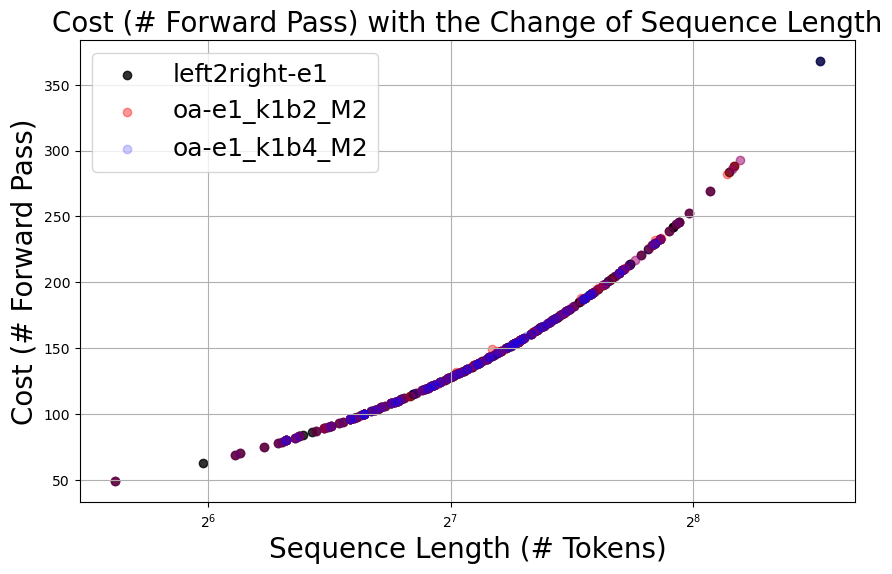

In [61]:
titles = [
    'left2right-e1', 
    'oa-e1_k1b2_M2', 'oa-e1_k1b4_M2', 
]

draw_cost_length_curves(results_sft_interleaved_cw1_r0[1], titles, colors_list)

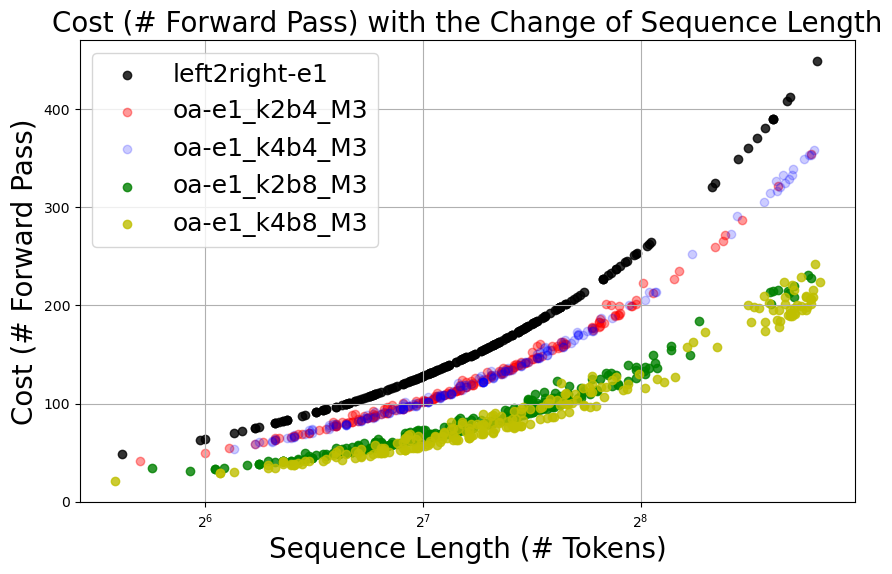

In [60]:
titles = [
    'left2right-e1', 
    'oa-e1_k2b4_M3', 'oa-e1_k4b4_M3', 
    'oa-e1_k2b8_M3', 'oa-e1_k4b8_M3'
]

draw_cost_length_curves(results_sft_interleaved_cw4_sym_r0[1], titles, colors_list)

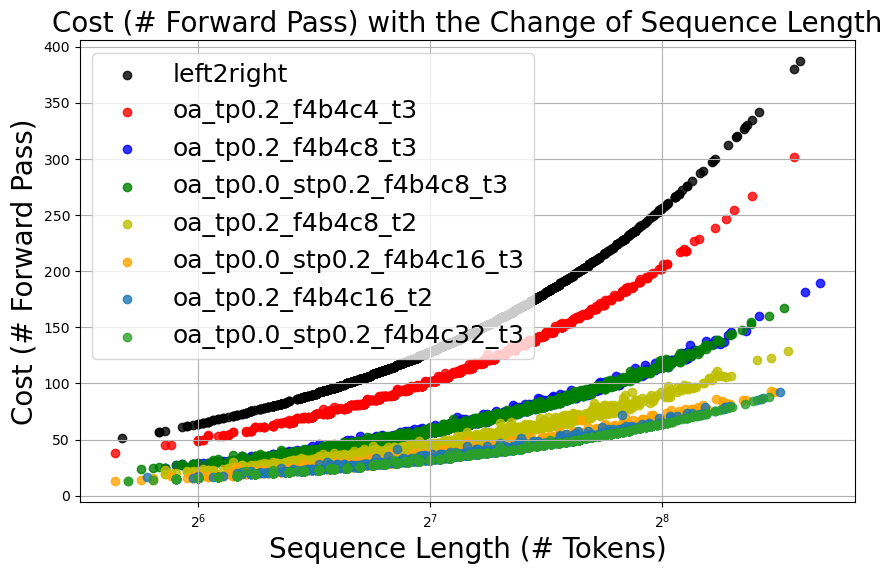

In [102]:
titles = [
    'left2right', 
    'oa_tp0.2_f4b4c4_t3', 'oa_tp0.2_f4b4c8_t3', 
    'oa_tp0.2_f4b4c8_t2', 'oa_tp0.2_f4b4c16_t2',
    'oa_tp0.0_stp0.2_f4b4c8_t3', 'oa_tp0.0_stp0.2_f4b4c16_t3', 'oa_tp0.0_stp0.2_f4b4c32_t3'
]

draw_cost_length_curves(results_sft_interleaved_cw4_r0[1], titles, colors_list,
                        indexes=[0, 1, 2, 5, 3, 6, 4, 7])

#### Accu--Cost

In [192]:
import itertools

def get_perform_cost(all_pa_pairs, all_tracks, force_l2r=False):
    indexes = [i for i in range(len(all_pa_pairs))]
    pairs = []
    for r in tqdm(range(len(indexes))):
        idxes_list = itertools.combinations(indexes, r=r + 1)
        for idxes in idxes_list:
            if force_l2r and 0 not in idxes: continue
            pa_pairs = [all_pa_pairs[i] for i in idxes]
            tracks = [all_tracks[i] for i in idxes]
            min_len = min([len(a) for a in pa_pairs])
            cost, accu = [], []
            for i in range(min_len):
                pas = [pa[i] for pa in pa_pairs]
                trs = [trk[i] for trk in tracks]
                accu.append(any([any(math_equal(xx, x[1]) for xx in x[0]) for x in pas]))
                x = 0
                for xx in trs:
                    for i, xxx in enumerate(xx):
                        if xxx[0] is None or tokenizer.eos_token_id in xxx[0] or i == len(xx) - 1:
                            x += i + 1
                            break
                cost.append(x)
            pairs.append((sum(cost) / max(1, len(cost)), sum(accu) / max(1, len(accu)) * 100))
    pairs = sorted(pairs, key=lambda x: x[0])
    return pairs

def draw_perform_cost_curves(all_pa_pairs, all_tracks, indexes=None):
    if indexes is not None:
        all_tracks = [all_tracks[i] for i in indexes]
        all_pa_pairs = [all_pa_pairs[i] for i in indexes]
    pairs = get_perform_cost(all_pa_pairs, all_tracks, force_l2r=True)
    pairs_oa = get_perform_cost(all_pa_pairs[1:], all_tracks[1:])
    plt.figure(figsize=(10, 5))
    x = [pair[0] for pair in pairs_oa]
    y = [pair[1] for pair in pairs_oa]
    plt.plot(x, y, marker='.', linestyle='-', label='order-agnostic only', color='b')
    x = [pair[0] for pair in pairs]
    y = [pair[1] for pair in pairs]
    plt.plot(x, y, marker='.', linestyle='-', label='order-agnostic + left2right', color='g')
    
    # plt.xscale('log', base=2)

    plt.title('Best-of-N Performance with the Change of Cost', fontsize=20)
    plt.xlabel('Cost (# Forward Pass)', fontsize=20)
    plt.ylabel('Performance (Accuracy)', fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()


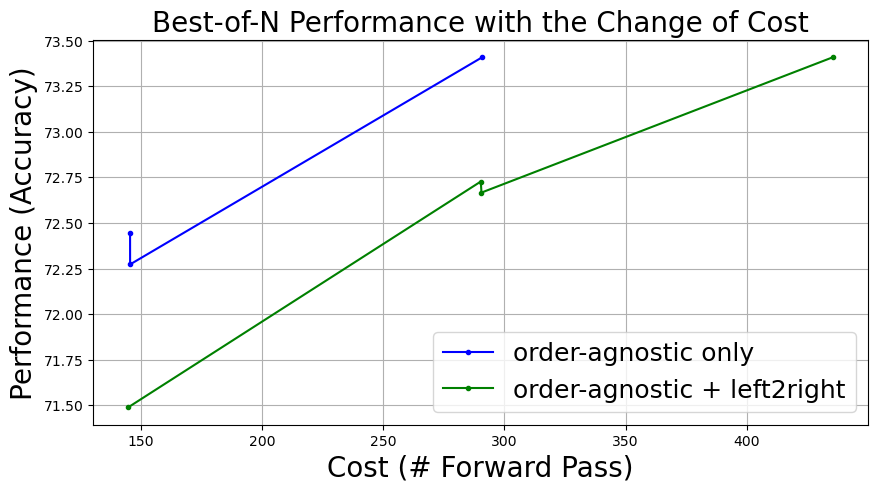

In [165]:
draw_perform_cost_curves(results_sft_interleaved_cw1_r0[2], results_sft_interleaved_cw1_r0[1])

100%|██████████| 4/4 [00:04<00:00,  1.10s/it]


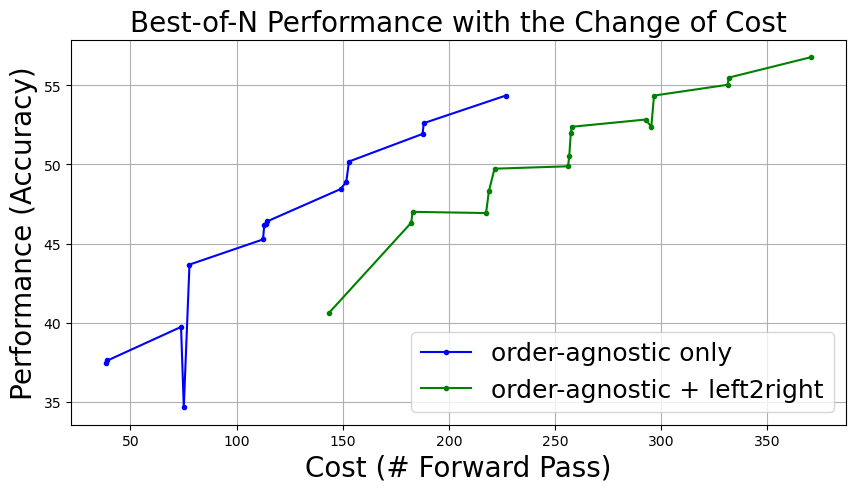

In [315]:
draw_perform_cost_curves(
    results_cw8_r025[2], results_cw8_r025[1],
    # indexes=[0, 1, 2, 3, 5, 6],
    indexes=[0, 1, 2, 3, 4],
)

100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


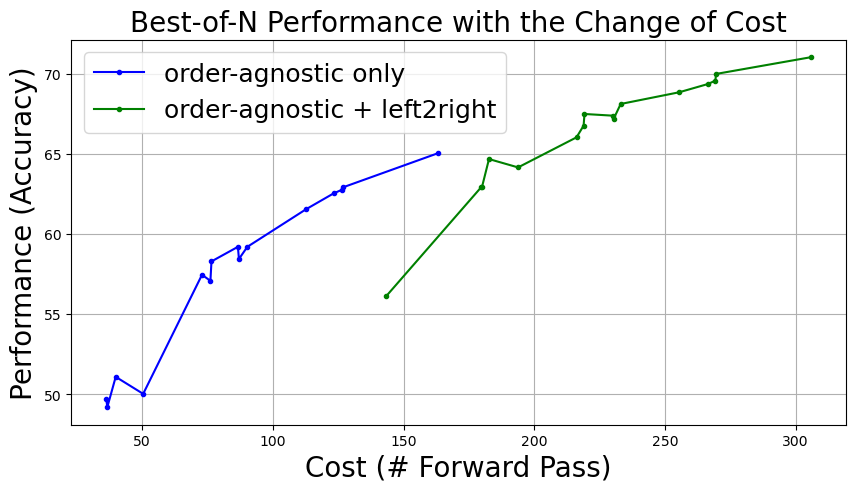

In [203]:
draw_perform_cost_curves(
    results_sft_interleaved_cw4_r0[2], results_sft_interleaved_cw4_r0[1],
    # indexes=[0, 1, 2, 3, 5, 6],
    indexes=[0, 3, 4, 6, 7],
)

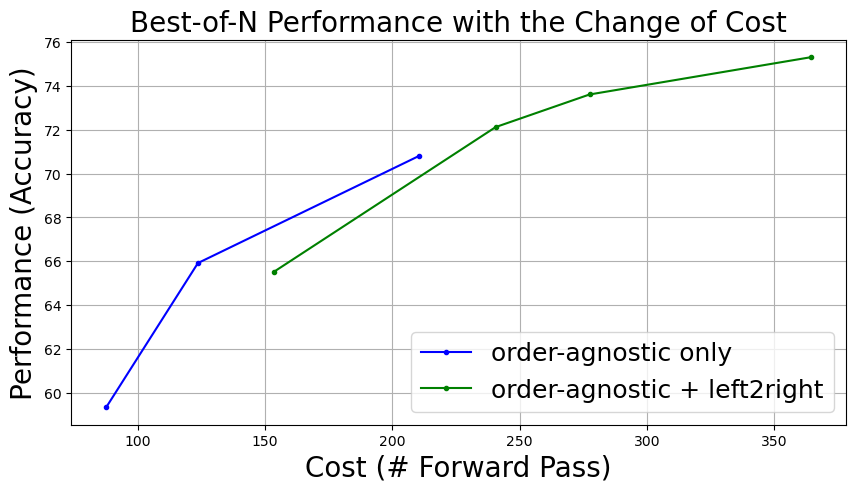

In [163]:
draw_perform_cost_curves(results_sft_interleaved_cw4_sym_r0[2], results_sft_interleaved_cw4_sym_r0[1],
                         indexes=[0, 1, 3])

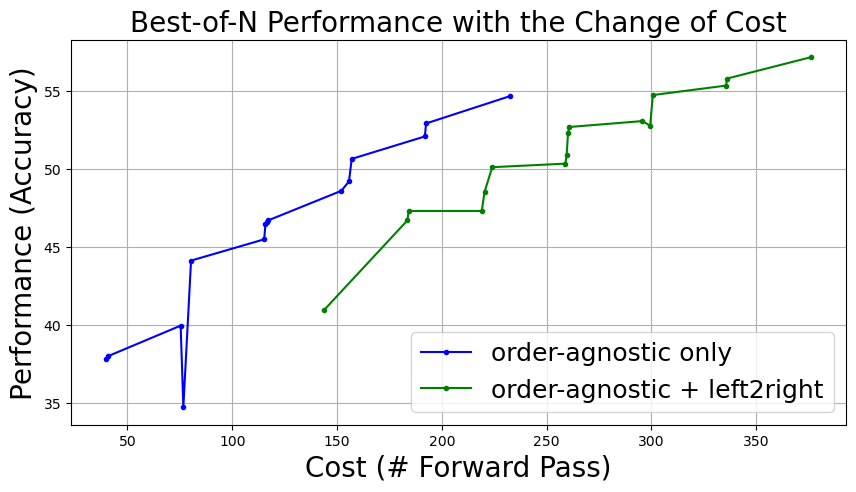

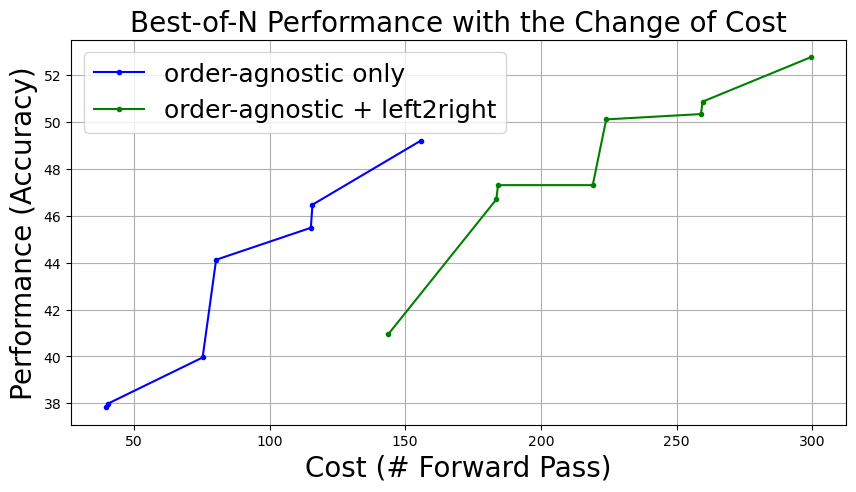

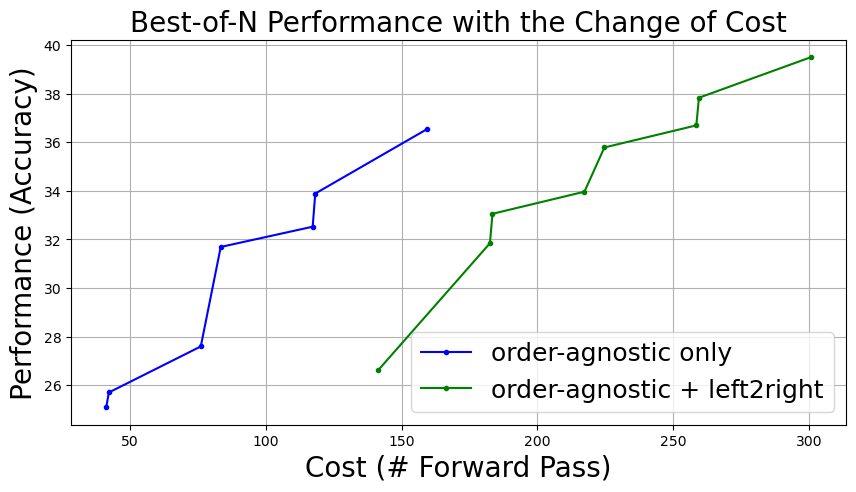

In [15]:
# draw_perform_cost_curves(results_cw8_r025[0], results_cw8_r025[1])
draw_perform_cost_curves(results_cw8_r025[0][:-1], results_cw8_r025[1][:-1])
draw_perform_cost_curves(results_cw8_nb2_r025[0], results_cw8_nb2_r025[1])

#### Accu--N

In [141]:
import itertools

def get_perform_N(accuracies, all_tracks, force_l2r=False):
    indexes = [i for i in range(len(accuracies))]
    pairs = []
    for r in range(len(indexes)):
        idxes_list = itertools.combinations(indexes, r=r + 1)
        for idxes in idxes_list:
            if force_l2r and 0 not in idxes: continue
            _accuracies = [accuracies[i] for i in idxes]
            _tracks = [all_tracks[i] for i in idxes]
            min_len = min([len(a) for a in _accuracies])
            final_accu, forward_cnt = [], []
            for i in range(len(_accuracies[0])):
                if i >= min_len: break
                rst = [
                    (0 if a[i] == [False] else any(any(x) for x in a[i]))
                    for a in _accuracies
                ]
                final_accu.append(any(rst))
                forward_cnt.append(sum([len(t[i]) for t in _tracks]))
            pairs.append((len(idxes), sum(final_accu) / max(1, len(final_accu)) * 100))
    pairs = sorted(pairs, key=lambda x: (x[0], x[1]))
    return pairs

def draw_perform_N_curves(accuracies, all_tracks):
    pairs = get_perform_N(accuracies, all_tracks, force_l2r=True)
    pairs_oa = get_perform_N(accuracies[1:], all_tracks[1:])
    plt.figure(figsize=(10, 5))
    x = [pair[0] for pair in pairs_oa]
    y = [pair[1] for pair in pairs_oa]
    plt.plot(x, y, marker='.', linestyle='-', label='order-agnostic only', color='b')
    x = [pair[0] for pair in pairs]
    y = [pair[1] for pair in pairs]
    plt.plot(x, y, marker='.', linestyle='-', label='order-agnostic + left2right', color='g')
    
    # plt.xscale('log', base=2)

    plt.title('Best-of-N Performance with the Change of N', fontsize=20)
    plt.xlabel('N (# Sequences)', fontsize=20)
    plt.ylabel('Performance (Accuracy)', fontsize=20)
    plt.grid(True)
    plt.legend(fontsize=18)
    plt.show()


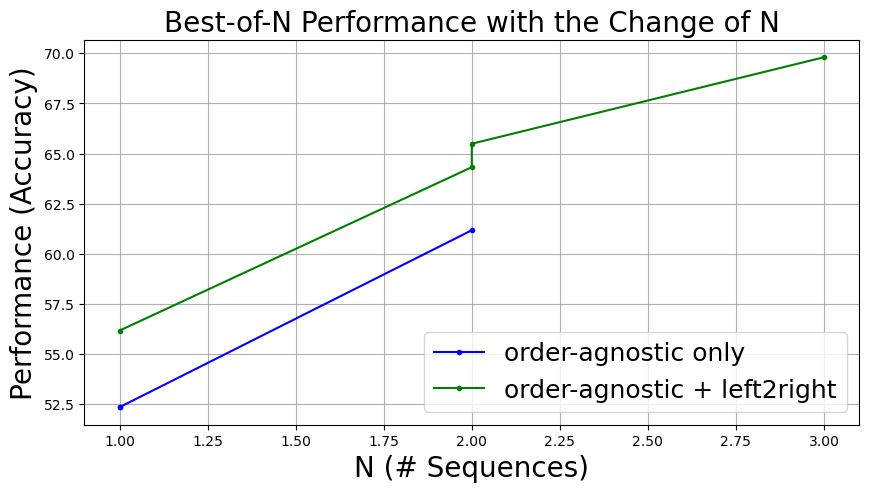

In [166]:
# draw_perform_N_curves(results_sft_interleaved_cw4_r0[0], results_sft_interleaved_cw4_r0[1])
draw_perform_N_curves(results_sft_interleaved_cw4_r0[0][:-1], results_sft_interleaved_cw4_r0[1][:-1])

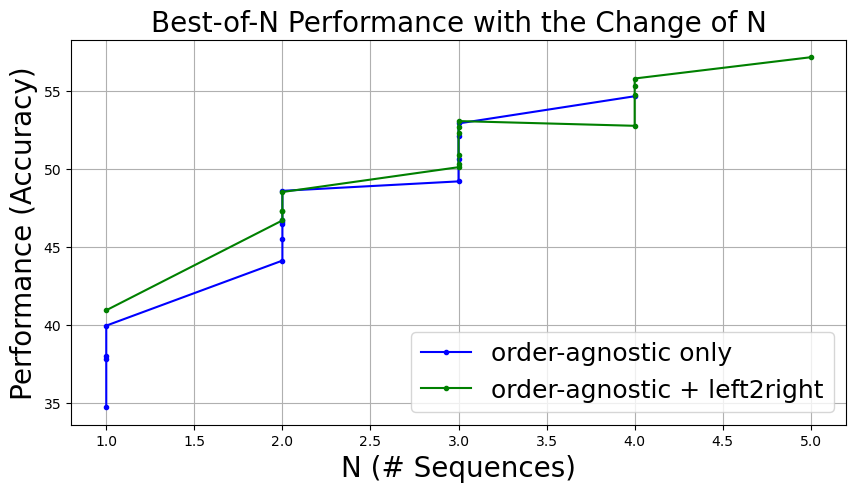

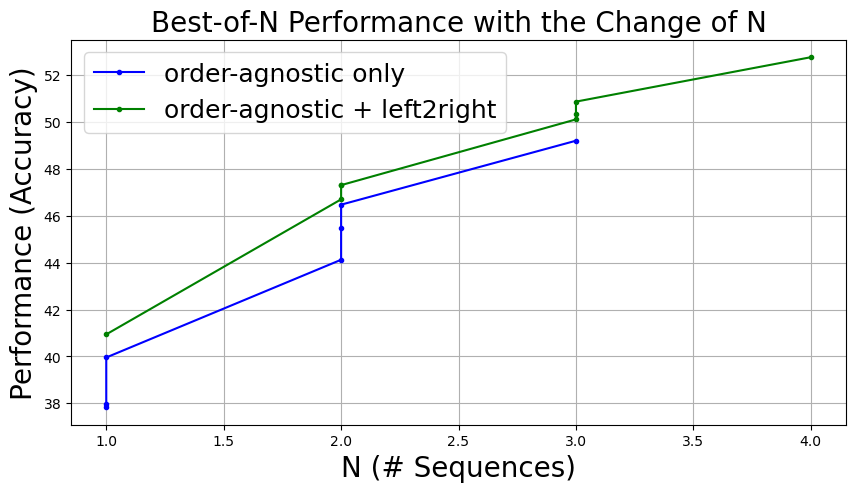

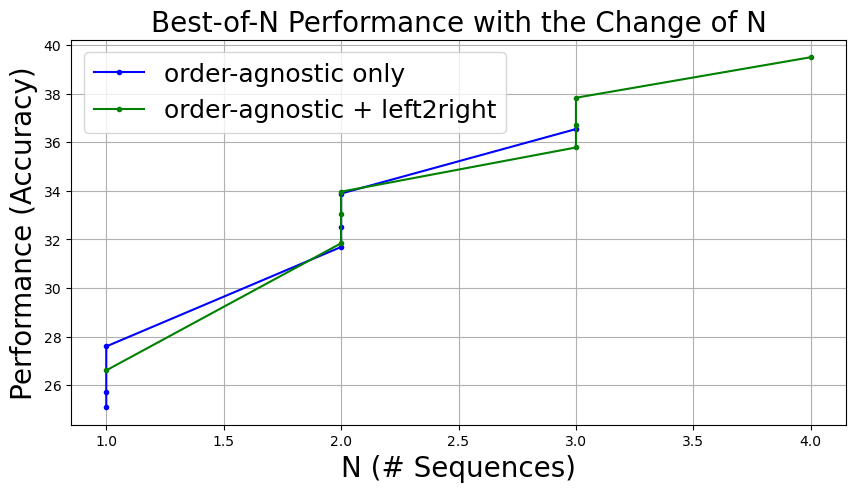

In [16]:
draw_perform_N_curves(results_cw8_r025[0], results_cw8_r025[1])
draw_perform_N_curves(results_cw8_r025[0][:-1], results_cw8_r025[1][:-1])
draw_perform_N_curves(results_cw8_nb2_r025[0], results_cw8_nb2_r025[1])

## Case

In [404]:
idx = 4
print('=== [left2right] ===')
base_trk = [x[0] for x in results_sft_interleaved_cw4_r0[1][5][idx]]
bid = -1
for i , t in enumerate(base_trk):
    if t is None:
        bid = i - 1
        break
    elif tokenizer.eos_token_id in t:
        bid = i
        break
print(tokenizer.decode(base_trk[bid]), f'\n{bid}===\n')
our_tracks = results_sft_interleaved_cw4_r0[1][5]
for i in range(len(our_tracks[idx])):
    i = len(our_tracks[idx]) - i - 1
    ids, pos = our_tracks[idx][i]
    if ids is None:
        print('\n*************\n')
        continue
    start_idx, end_idx = min(pos), max(pos)
    print(f'[step {i + 1}]\n', tokenizer.decode([ids[pos.index(x)] if x in pos else my_pad_token_id for x in range(start_idx, end_idx + 1)]))

=== [left2right] ===
To find the average number of birds Mack saw in a day, we need to add up the total number of birds he saw and divide it by the number of days.
On one one and two, Mack saw 50 birds.
On day three, he saw none.
On day four and five, he saw 120 birds each day, so a total of 120 + 120 = 240 birds.
On day six, he saw 20 birds.
On day seven, he saw 90 birds.
The total number of birds Mack saw is 50 + 240 + 20 + 90 = 320 birds.
Since there are 7 days in a week, we divide the total number of birds by 7 to find the average.
320 birds / 7 days = 40 birds per day.
Therefore, Mack saw, average average, 40 birds in a day.
#### 40
The answer is: 40</s> 
101===

[step 166]
 To find the average number of birds Mack saw in a day, we need to add up the total number of birds he saw and divide it by the number of days.
On one one and two, Mack saw 50 birds.
On day three, he saw none.
On day four and five, he saw 120 birds each day, so a total of 120 + 120 = 240 birds.
On day six, he s